In [2]:
#importing pytorch to use gpu instead of my cpu
import torch
print(torch.cuda.is_available())
!nvidia-smi


True
Sun Aug 25 07:21:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [3]:
#imports
!pip install ultralytics -q
!pip install wandb
from ultralytics import YOLO
import os
import pandas as pd
from glob import glob
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import shutil
import yaml
from IPython.display import Image
from datetime import datetime

In [4]:
#configure wandb
WANDB_API_KEY = "6f24595c7287bf6fc1ca67b40a2bc85e7ae14e13"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="Animal Type Detection")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ethelnaggita (ethelnaggita-makerere-university). Use `wandb login --relogin` to force relogin


In [5]:
#download dataset
os.makedirs('animal_type_dataset', exist_ok=True)
!git clone -b animal_type_detection_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./animal_type_dataset

Cloning into './animal_type_dataset'...
remote: Enumerating objects: 15246, done.
remote: Counting objects: 100% (3683/3683), done.
remote: Compressing objects: 100% (3664/3664), done.
remote: Total 15246 (delta 20), reused 3677 (delta 17), pack-reused 11563 (from 1)
Receiving objects: 100% (15246/15246), 1.30 GiB | 14.86 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (13932/13932), done.


In [6]:
# Change to the directory where the repository was cloned
%cd /kaggle/working/animal_type_dataset

# List files to find 'label_train.csv'
!ls

/kaggle/working/animal_type_dataset
0001  0004  0007				  label_train.csv
0002  0005  README.md				  metric.ipynb
0003  0006  animal-type-detection-tutorial.ipynb  sample_submission.csv


In [7]:
#load label data
df = pd.read_csv('label_train.csv')
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax  
0   562  
1   360  
2   312  
3   469  
4   336

In [8]:
#determining proportion of each class
df['class'].value_counts(normalize=True)

class
cow     0.704333
pig     0.165376
goat    0.130291
Name: proportion, dtype: float64

In [9]:
# Count total entries in the 'filename' column
total_filenames = df['filename'].count()
total_filenames

9947

In [10]:
#Checking whether there exists any duplicate images
df['filename'].duplicated().any()

True

In [11]:
#Function to draw a bounding box around images for concentration on the image
def drawBoundingBoxAroundImage(image_path, bbox, class_):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    cv2.putText(img, class_, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [12]:
#get file path for image files by adding filepath column to dataframe
#df['filepath'] = df.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)


# df['filepath'] = df.apply(lambda row: (glob(f'animal_type_dataset/**/{row.filename}') or [None])[0], axis=1)
import glob
def find_file(filename):
    for dir in ['0001', '0002', '0003', '0004', '0005', '0006', '0007']:
        path = f'{dir}/{filename}'
        if glob.glob(path):
            return path
    return None

df['filepath'] = df['filename'].apply(find_file)


In [13]:
#determining number of unique file names and file paths now present
len(df.filename.unique()), len(df.filepath.unique())

(9808, 9808)

In [14]:
total_rows = len(df)
print(f"Total number of entries/rows in the DataFrame: {total_rows}")

Total number of entries/rows in the DataFrame: 9947


In [15]:
# Print original number of rows
print(f"Original number of rows: {len(df)}")

# Remove duplicates based on both filename and filepath
df_unique = df.drop_duplicates(subset=['filename', 'filepath'])

# Print number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df_unique)}")

# Print number of rows removed
print(f"Number of duplicate rows removed: {len(df) - len(df_unique)}")

# Assign the deduplicated DataFrame back to df
df = df_unique

# Reset the index if needed
df = df.reset_index(drop=True)

# Verify the number of unique filenames and filepaths
print(f"Number of unique filenames: {len(df['filename'].unique())}")
print(f"Number of unique filepaths: {len(df['filepath'].unique())}")

Original number of rows: 9947
Number of rows after removing duplicates: 9808
Number of duplicate rows removed: 139
Number of unique filenames: 9808
Number of unique filepaths: 9808


In [16]:
#printing the first 5 rows of the label_train dataframe after adding filepath column
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax                                           filepath  
0   562  0006/cb3854ef-2abc-4d44-bd1f-807a38660c6168942...  
1   360  0003/4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e8049770...  
2   312  0006/cb279fc1-67a3-413c-b3f8-c0594bf0507a14073...  
3   469  0005/97e0bf2d-4548-4c25-9bd7-5a867b86541536281...  
4   336  0004/747cef5f-e7dc-4657-b0e4-225450446a6310151...

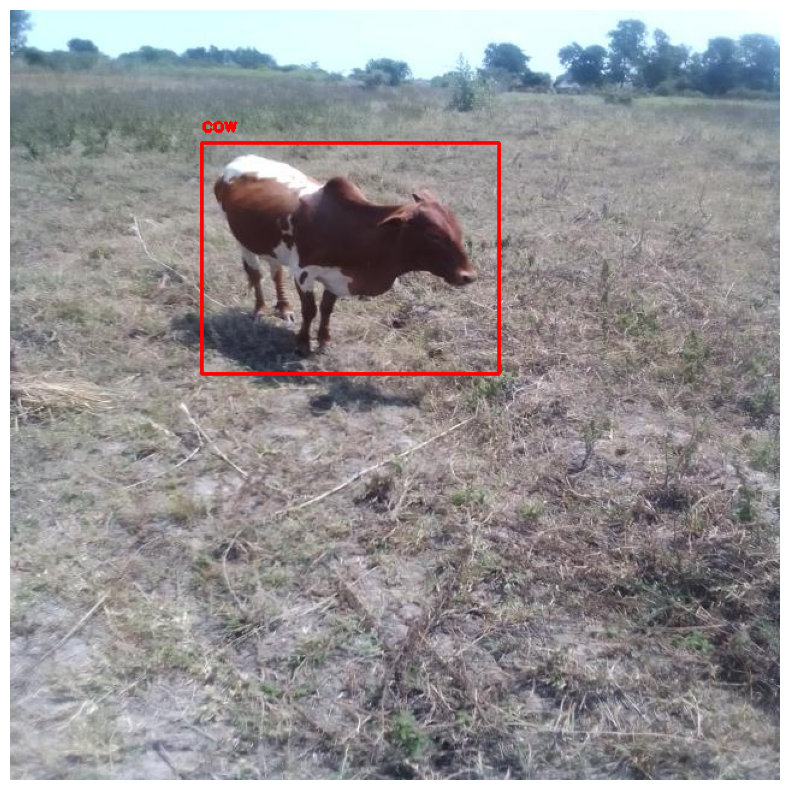

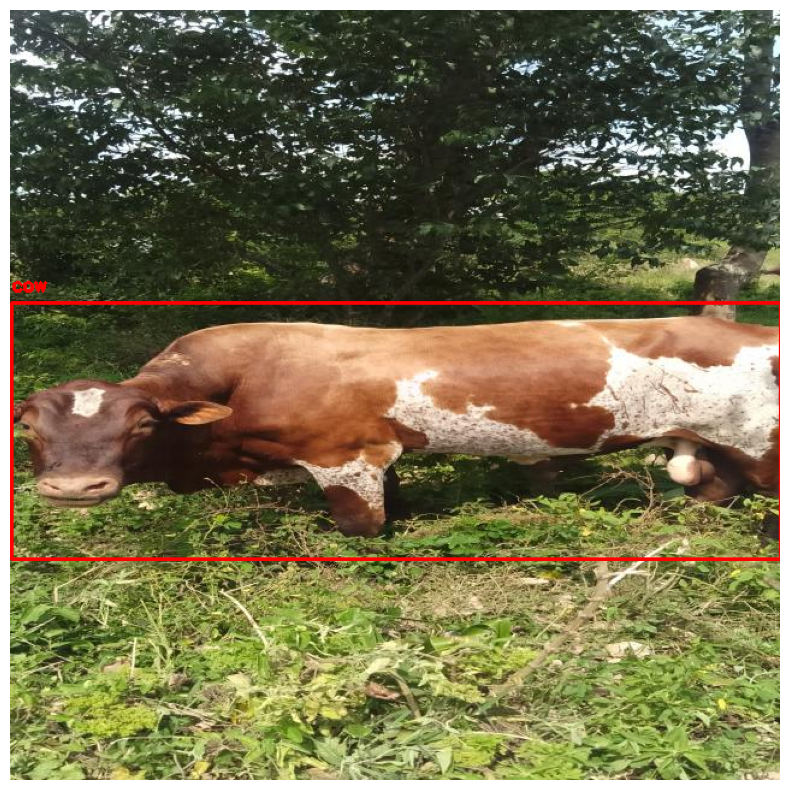

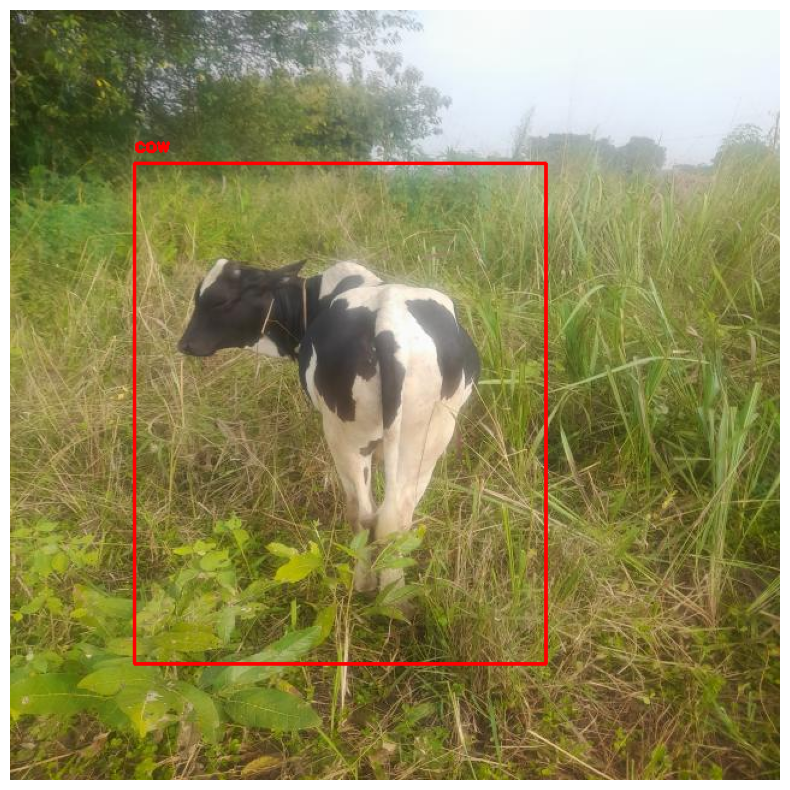

6536    None
4001    None
7897    None
dtype: object

In [17]:
#displaying three random pictures from the dataset with bound boxes and their classes
df.sample(3).apply(lambda row: drawBoundingBoxAroundImage(row.filepath, [row.xmin, row.ymin, row.xmax, row.ymax], row['class']), axis=1)

In [18]:
#converting bounding box coordinates from the VOC (Visual Object Classes) format to the YOLO (You Only Look Once) format.
def convert_voc_to_yolo(xmin, ymin, xmax, ymax, img_width=640, img_height=640):
    # Calculate the center of the bounding box
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Normalize the values by the dimensions of the image
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return [center_x, center_y, width, height]

In [19]:
#splitting the dataset/dataframe into training(70%) and validation data(30%)
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=32)

In [20]:
# Print the number of images in each set
print(f"Number of images in training set: {len(df_train)}")
print(f"Number of images in validation set: {len(df_valid)}")


Number of images in training set: 6865
Number of images in validation set: 2943


In [21]:
#defining a list of the labels
labels = ['cow', 'goat', 'pig']

In [22]:
#creating directories for storing train images and labels in a format ready for yolo model
os.makedirs('yolo_dataset/train/labels', exist_ok=True)
os.makedirs('yolo_dataset/train/images', exist_ok=True)
train_grouping = df_train.groupby('filepath')
for index, group in enumerate(train_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list()
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/train/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/train/images')

In [23]:
#creating directories for storing validation images and labels in a format ready for yolo model
os.makedirs('yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('yolo_dataset/valid/images', exist_ok=True)
valid_grouping = df_valid.groupby('filepath')
for index, group in enumerate(valid_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list()
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/valid/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/valid/images')

In [24]:
#displaying the first five rows of sample_submission.csv file
df_sample_submission = pd.read_csv('sample_submission.csv')
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0

In [25]:
#get file path for test image files
import glob
# df_sample_submission['filepath'] = df_sample_submission.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)

def find_file(filename):
    for dir in ['0001', '0002', '0003', '0004', '0005', '0006', '0007']:
        path = f'{dir}/{filename}'
        if glob.glob(path):
            return path
    return None

df_sample_submission['filepath'] = df_sample_submission['filename'].apply(find_file)


df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax                                           filepath  
0     0     0     0  0006/dc3bf168-1589-486d-8152-438d0e4a56f241416...  
1     0     0     0  0001/0691e0da-6b49-414e-a0d9-e6caa2fbe3fa27207...  
2     0     0     0  0003/68072e08-d602-4daa-9b2e-b53e3075d45d79968...  
3     0     0     0  0003/57f59f63-9ec6-4d0b-b837-808a089f3d8766918...  
4     0     0     0  0004/7091ebde-40ba-478c-b119-2c558dfe133a86893...

In [26]:
#creating variable to store all the unique file paths of the images in the sample_submission dataframe
test_file_paths = df_sample_submission.filepath.unique()

In [27]:
#determing the number of unique file paths of the images in the sample_submission dataframe
print(len(test_file_paths))

9811


In [28]:
#create test directory containing images of the unique file paths
os.makedirs('yolo_dataset/test/images', exist_ok=True)
for file_path in test_file_paths:
    shutil.copy(file_path, 'yolo_dataset/test/images')

In [29]:
import os
from collections import Counter
import glob

# Define the mapping of class IDs to class names
class_id_to_name = {
    0: 'cow',
    1: 'goat',
    2: 'pig'
}

def count_classes(dataset_path):
    class_counts = Counter()

    # Find all txt files in the labels directory
    label_files = glob.glob(os.path.join(dataset_path, 'labels', '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # The class ID is the first number in each line
                class_counts[class_id] += 1

    # Convert class ID counts to class name counts
    class_name_counts = {class_id_to_name[class_id]: count for class_id, count in class_counts.items()}

    return class_name_counts

# Count classes in training set
train_path = '/kaggle/working/animal_type_dataset/yolo_dataset/train'
train_counts = count_classes(train_path)
print(f"Number of classes in training set: {len(train_counts)}")
print(f"Class distribution in training set: {train_counts}")

# Count classes in validation set
val_path = '/kaggle/working/animal_type_dataset/yolo_dataset/valid'
val_counts = count_classes(val_path)
print(f"Number of classes in validation set: {len(val_counts)}")
print(f"Class distribution in validation set: {val_counts}")

# Get the unique classes across both sets (assuming they are the same)
unique_classes = set(train_counts.keys()).union(set(val_counts.keys()))
print(f"Total unique classes across both sets: {len(unique_classes)}")


Number of classes in training set: 3
Class distribution in training set: {'cow': 4855, 'pig': 1142, 'goat': 868}
Number of classes in validation set: 3
Class distribution in validation set: {'cow': 2059, 'goat': 405, 'pig': 479}
Total unique classes across both sets: 3


In [30]:
import os
import shutil
import glob
import random

def oversample_class(class_id, target_count, images_dir, labels_dir, output_images_dir, output_labels_dir):
    class_images = []
    class_labels = []

    # Find all label files
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))

    for lbl_path in label_files:
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            # Check if the label file contains the desired class
            if any(int(line.split()[0]) == class_id for line in lines):
                # Get the corresponding image file
                img_path = os.path.join(images_dir, os.path.basename(lbl_path).replace('.txt', '.jpg'))
                if os.path.exists(img_path):
                    class_images.append(img_path)
                    class_labels.append(lbl_path)

    if len(class_images) == 0:
        print(f"No images found for class {class_id}")
        return

    current_count = len(class_images)
    images_needed = target_count - current_count

    for i in range(images_needed):
        idx = random.randint(0, len(class_images) - 1)
        img_path = class_images[idx]
        lbl_path = class_labels[idx]

        new_img_path = os.path.join(output_images_dir, f'oversampled_{i}_{os.path.basename(img_path)}')
        new_lbl_path = os.path.join(output_labels_dir, f'oversampled_{i}_{os.path.basename(lbl_path)}')

        shutil.copy(img_path, new_img_path)
        shutil.copy(lbl_path, new_lbl_path)

# Paths to your datasets
train_images_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/images'
train_labels_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/labels'
output_images_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/images'
output_labels_dir = '/kaggle/working/animal_type_dataset/yolo_dataset/train/labels'

# Define target counts
target_count = 4855  # Number of cow images

# Oversample 'pig' (class_id = 2) and 'goat' (class_id = 1)
oversample_class(2, target_count, train_images_dir, train_labels_dir, output_images_dir, output_labels_dir)
oversample_class(1, target_count, train_images_dir, train_labels_dir, output_images_dir, output_labels_dir)


In [31]:
import os
from collections import Counter
import glob

def count_classes_by_label(dataset_path):
    class_counts = Counter()

    # Find all txt files in the labels directory
    label_files = glob.glob(os.path.join(dataset_path, 'labels', '*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # The class ID is the first number in each line
                class_counts[class_id] += 1

    return class_counts

# Count classes in training set
train_path = '/kaggle/working/animal_type_dataset/yolo_dataset/train'
train_class_distribution = count_classes_by_label(train_path)
print(f"New class distribution in training set: {train_class_distribution}")


New class distribution in training set: Counter({1: 4855, 0: 4855, 2: 4855})


In [32]:
#creating a YAML configuration file for the YOLO (You Only Look Once) object detection model.
data = {
'names': labels,
'nc': len(labels),
'test': '/kaggle/working/animal_type_dataset/yolo_dataset/test/images',
'train': '/kaggle/working/animal_type_dataset/yolo_dataset/train/images',
'val': '/kaggle/working/animal_type_dataset/yolo_dataset/valid/images'
}
with open('yolo_dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [ ]:
#train model using a pre trained yolo model
model = YOLO("yolov8m.pt")
model.train(data="yolo_dataset/data.yaml", epochs=20, imgsz=640, plots=True, lr0=0.01, lrf=0.01, batch=16)

100%|██████████| 49.7M/49.7M [00:00<00:00, 52.5MB/s]


Ultralytics YOLOv8.2.81 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 755k/755k [00:00<00:00, 80.0MB/s]
2024-08-25 07:24:07,058	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-25 07:24:07,593	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 249MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:271: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/working/animal_type_dataset/yolo_dataset/train/labels... 14565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14565/14565 [00:11<00:00, 1283.30it/s]


train: New cache created: /kaggle/working/animal_type_dataset/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/animal_type_dataset/yolo_dataset/valid/labels... 2943 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2943/2943 [00:02<00:00, 1140.59it/s]


val: New cache created: /kaggle/working/animal_type_dataset/yolo_dataset/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.73G      1.418      2.017      1.809         14        640: 100%|██████████| 911/911 [09:34<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:40<00:00,  2.26it/s]

                   all       2943       2943      0.411      0.459      0.358      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.67G      1.433      1.884      1.805         11        640: 100%|██████████| 911/911 [09:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.34it/s]

                   all       2943       2943      0.505      0.524      0.465      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.56G       1.38      1.791      1.749          9        640: 100%|██████████| 911/911 [09:22<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.35it/s]

                   all       2943       2943      0.456      0.573      0.502      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.66G      1.326      1.707      1.711         12        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.35it/s]

                   all       2943       2943      0.619      0.645      0.639      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.64G      1.288      1.621      1.676         11        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.35it/s]

                   all       2943       2943      0.723      0.683      0.706      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.68G      1.261      1.549      1.654         19        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:38<00:00,  2.36it/s]

                   all       2943       2943      0.702       0.68        0.7       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.57G      1.235      1.495      1.634         14        640: 100%|██████████| 911/911 [09:20<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:38<00:00,  2.36it/s]

                   all       2943       2943      0.629      0.673      0.639      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.66G      1.209      1.447      1.613         13        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:38<00:00,  2.36it/s]

                   all       2943       2943      0.726      0.678      0.706      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.62G      1.186      1.407      1.597          9        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:38<00:00,  2.36it/s]

                   all       2943       2943      0.738       0.72      0.745      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.67G      1.168      1.373      1.578         12        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.34it/s]

                   all       2943       2943      0.735      0.711      0.739      0.415


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.57G      1.199      1.081      1.768          5        640: 100%|██████████| 911/911 [09:20<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.36it/s]

                   all       2943       2943      0.746      0.722      0.745      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.66G       1.16      1.019      1.727          5        640: 100%|██████████| 911/911 [09:20<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.36it/s]

                   all       2943       2943      0.764      0.736      0.774      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.65G       1.12      0.954      1.695          5        640: 100%|██████████| 911/911 [09:21<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.34it/s]

                   all       2943       2943      0.759      0.753       0.76      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.68G      1.088     0.9096      1.669          5        640: 100%|██████████| 911/911 [09:20<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.35it/s]

                   all       2943       2943      0.763      0.726      0.751      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.57G      1.044      0.848      1.629          5        640: 100%|██████████| 911/911 [09:20<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.35it/s]

                   all       2943       2943      0.752      0.755      0.749      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.66G     0.9993     0.8091      1.593          5        640: 100%|██████████| 911/911 [09:20<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:39<00:00,  2.33it/s]

                   all       2943       2943      0.743       0.75       0.75      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.65G     0.9609     0.7573       1.56         16        640:  41%|████      | 374/911 [03:50<05:32,  1.61it/s]

In [ ]:
#list yolo generated training files
os.listdir("runs/detect/train/")

In [ ]:
Image(filename='runs/detect/train/results.png', width=600)

In [ ]:
Image(filename='runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
#make predictions
results = model.predict(source='yolo_dataset/test/images', conf=0.25, save=True, project=f"runs/detect", name="predict", exist_ok=True)

In [ ]:
#display predictions
for image_path in glob('runs/detect/predict/*.jpg')[:2]:
    display(Image(filename=image_path, width=1000,height=1000))
    print("\n")

In [ ]:
#create submission file
data = []
for result in results:
    image_name = os.path.basename(result.path)
    class_names =result.names
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        class_name = class_names[int(cls)]
        bbox = box.cpu().tolist()
        record = [image_name, class_name, conf.item()]+bbox
        data.append(record)

with open(f'submission{int(datetime.now().timestamp())}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['filename', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
    writer.writerow(header)
    writer.writerows(data)